In [2]:
from data_loader import train, test
from preprocessing import *
from clickfeatures import regularity, procrastination
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [4]:
proc = build_procrastination(train.studentVle, train.assessments)
time_df = build_timebased_regularity(train.studentVle, train.assessments)
act_df = build_activitybased_regularity(train.studentVle, train.vle, train.assessments)

In [5]:
identifiers = ['code_module', 'code_presentation', 'id_student']
df = time_df.merge(train.studentInfo[identifiers + ['final_result']], 
                        on=identifiers, how='inner')
df = df.merge(act_df, on=identifiers, how='inner')
df = df.merge(proc, on=identifiers, how='inner')
df['group'] = df['final_result'].map({
    'Pass': 'Pass', 
    'Withdrawn': 'Withdrawn',
    'Fail': 'Fail',
    'Distinction': 'Pass'})

Text(0.5,1,u'Consistency')

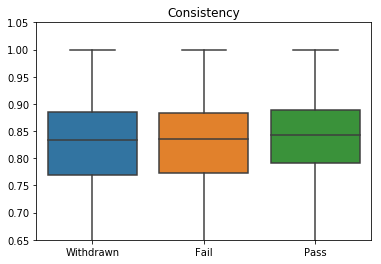

In [6]:
plt.ylim(0.65, 1.05)
ax = sns.boxplot(x='group', y='consistency', 
            data=df, order=['Withdrawn', 'Fail', 'Pass'])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Consistency')

Text(0.5,1,u'Concentration')

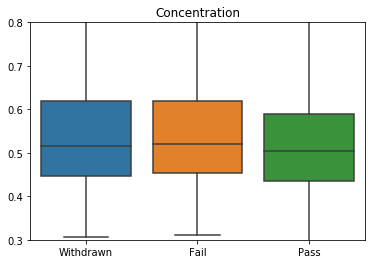

In [7]:
plt.ylim(0.3, .8)
ax = sns.boxplot(x='group', y='concentration', 
            data=df, order=['Withdrawn', 'Fail', 'Pass'])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Concentration')

Text(0.5,1,u'Procastination')

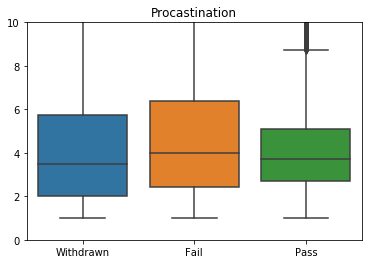

In [8]:
#plt.ylim(0.3, .8)
plt.ylim(0, 10)
ax = sns.boxplot(x='group', y='proc2', 
            data=df, order=['Withdrawn', 'Fail', 'Pass'])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Procastination')

Text(0.5,1,u'Procastination')

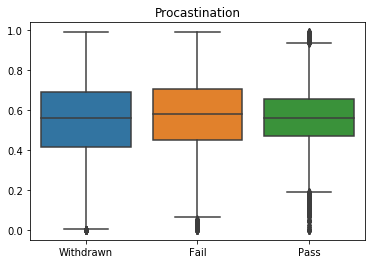

In [9]:
ax = sns.boxplot(x='group', y='proc3', 
            data=df, order=['Withdrawn', 'Fail', 'Pass'])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Procastination')

In [10]:
metrics = ['pwd', 'ws1', 'ws2', 'ws3', 'fwd', 'concentration', 'consistency', 'proc1', 'proc2', 'proc3']
group = ['Withdrawn', 'Fail', 'Pass']

for metric in metrics:
    arrs = []
    for g in group:
        mask = (df['group'] == g) & (pd.notnull(df[metric]))
        arrs.append(df[mask][metric].tolist())
    statistic, p = stats.f_oneway(*arrs)
    print('one way anova for {} is, with statistics = {} and p-value = {}'.
         format(metric, statistic, p))

one way anova for pwd is, with statistics = 218.018390921 and p-value = 3.22265759227e-94
one way anova for ws1 is, with statistics = 630.430008703 and p-value = 7.47263271108e-265
one way anova for ws2 is, with statistics = 175.654984654 and p-value = 3.69748881177e-76
one way anova for ws3 is, with statistics = 135.125418592 and p-value = 5.98074687797e-59
one way anova for fwd is, with statistics = 127.379500097 and p-value = 1.22934870519e-55
one way anova for concentration is, with statistics = 69.3759733284 and p-value = 9.65658598699e-31
one way anova for consistency is, with statistics = 54.7213828187 and p-value = 2.04378926494e-24
one way anova for proc1 is, with statistics = 26.5670366066 and p-value = 3.01241764237e-12
one way anova for proc2 is, with statistics = 56.7003050256 and p-value = 2.83056725098e-25
one way anova for proc3 is, with statistics = 27.2557096271 and p-value = 1.51604250933e-12


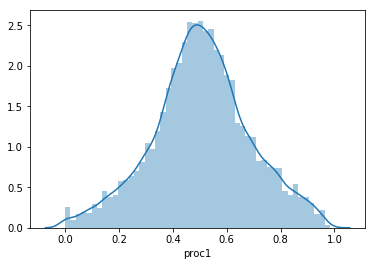

In [11]:
sns.distplot(df['proc1'])

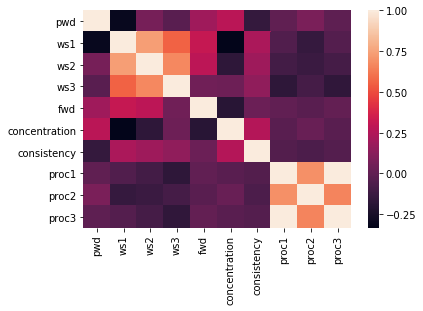

In [12]:
sns.heatmap(df[metrics].corr())